<a href="https://colab.research.google.com/github/SossouAdjisse/TaxiRideDurationPrediction/blob/main/TaxiRideDurationPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------
---------------
# PROJECT: Predictive Analytics: Taxi Ride Duration Prediction

###### **Sossou S Adjisse**
---------------
---------------
## **Objective**

This project aims at using Automated feature engineering to create new features, and  build predictive models, for predicting the duration for taxi ride. This prediction will help a typical taxi company to efficiently assign the cabs to riders so that the service is free of hassle. To do this, I will start the model with simple features and gradually improve the feature definitions and examine the accuracy of the system. More precisely, I will be executing the following:
  * Install the dependencies
  * Load the data as pandas dataframe
  * Perform EDA on the dataset
  * Build features with Deep Feature Synthesis using the featuretools
  * Create **Linear Regression**, **Decision Tree**, and **Random Forest** models 

-----------------
## **Dataset**
-----------------
* The three datasets used for this project can be found [HERE](https://drive.google.com/drive/folders/1JlFj6sLQNgJaPcD-T12jsxX04wk1HzAS?usp=sharing). The dataset  contains information regarding the taxi trips, its duration, etc. in New York City.

The ``trips`` table has the following fields:
* **id:** which uniquely identifies the trip
* **vendor_id:**  is the taxi cab company - in our case study we have data from three different: cab companies
* **pickup_datetime:**  the time stamp for pickup
* **dropoff_datetime:**  the time stamp for drop-off
* **passenger_count:** the number of passengers for the trip
* **trip_distance:** total distance of the trip in miles 
* **pickup_longitude:** the longitude for pickup
* **pickup_latitude:** the latitude for pickup
* **dropoff_longitude:** the longitude of dropoff 
* **dropoff_latitude:** the latitude of dropoff
* **payment_type:** how the passenger paid for the trip: 1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided
* **trip_duration:** the duration we would like to predict using other fields 
* **pickup_neighborhood:** a one or two letter id of the neighborhood where the trip started
* **dropoff_neighborhood:** a one or two letter id of the neighborhood where the trip ended

# Step 1: Loading packages & data sets, and performing Exploratory Data Analysis (EDA)

In [100]:
# Installing featuretools library
!pip install featuretools==0.27.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing the Necessary libraries

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Feataurestools for feature engineering
import featuretools as ft

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Importing gradient boosting regressor, to make prediction
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#importing primitives
from featuretools.primitives import (Minute, Hour, Day, Month,
                                     Weekday, IsWeekend, Count, Sum, Mean, Median, Std, Min, Max)

print(ft.__version__)
%load_ext autoreload
%autoreload 2

0.27.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
# Setting global random seed
np.random.seed(40)

# To load the dataset
def load_nyc_taxi_data():
    trips = pd.read_csv('trips.csv',
                        parse_dates=["pickup_datetime","dropoff_datetime"],
                        dtype={'vendor_id':"category",'passenger_count':'int64'},
                        encoding='utf-8')
    trips["payment_type"] = trips["payment_type"].apply(str)
    trips = trips.dropna(axis=0, how='any', subset=['trip_duration'])

    pickup_neighborhoods = pd.read_csv("pickup_neighborhoods.csv", encoding='utf-8')
    dropoff_neighborhoods = pd.read_csv("dropoff_neighborhoods.csv", encoding='utf-8')

    return trips, pickup_neighborhoods, dropoff_neighborhoods

# To preview first five rows. 
def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values().head(n).index
    return df.loc[order]


# To compute features using automated feature engineering. 
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix


# To generate train and test dataset
def get_train_test_fm(feature_matrix, percentage):
    nrows = feature_matrix.shape[0]
    head = int(nrows * percentage)
    tail = nrows-head
    X_train = feature_matrix.head(head)
    y_train = X_train['trip_duration']
    X_train = X_train.drop(['trip_duration'], axis=1)
    imp = SimpleImputer()
    X_train = imp.fit_transform(X_train)
    X_test = feature_matrix.tail(tail)
    y_test = X_test['trip_duration']
    X_test = X_test.drop(['trip_duration'], axis=1)
    X_test = imp.transform(X_test)

    return (X_train, y_train, X_test,y_test)



# To see the feature importance of variables in the final model
def feature_importances(model, feature_names, n=5):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0], f[1]))

## Load the Datasets

In [103]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
649598,679634,1,2016-04-30 11:45:59,2016-04-30 11:47:47,1,0.50,-73.994919,40.755226,-74.000351,40.747917,1,108.0,D,AG
649599,679635,2,2016-04-30 11:46:04,2016-04-30 11:47:41,2,0.33,-73.978935,40.777172,-73.981888,40.773136,2,97.0,AV,AV
649600,679636,2,2016-04-30 11:46:39,2016-04-30 11:58:02,1,1.78,-73.998207,40.745201,-73.990265,40.729023,2,683.0,AP,H
649601,679637,2,2016-04-30 11:46:44,2016-04-30 11:55:42,1,1.40,-73.987129,40.739429,-74.007370,40.743511,2,538.0,R,Q
649602,679638,2,2016-04-30 11:47:30,2016-04-30 11:54:00,1,1.12,-73.942375,40.790768,-73.952095,40.777145,2,390.0,J,AM
649603,679639,1,2016-04-30 11:47:38,2016-04-30 11:57:22,2,1.90,-73.960800,40.769920,-73.978966,40.785698,1,584.0,K,I
649604,679640,1,2016-04-30 11:47:49,2016-04-30 12:01:05,1,4.30,-74.013885,40.709515,-73.987213,40.722343,2,796.0,AU,AC
649605,679641,1,2016-04-30 11:48:17,2016-04-30 12:01:02,1,2.90,-73.975426,40.757584,-73.999016,40.722027,1,765.0,A,X
649606,679642,1,2016-04-30 11:49:44,2016-04-30 12:00:03,1,1.30,-73.989815,40.750454,-74.000473,40.762352,2,619.0,D,P


## Display first five rows

In [104]:
trips.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
1,1,2,2016-01-01 00:01:45,2016-01-01 00:27:38,1,13.70,-73.956169,40.707756,-73.939949,40.839558,1,1553.0,Z,S
2,2,1,2016-01-01 00:01:47,2016-01-01 00:21:51,2,5.30,-73.993103,40.752632,-73.953903,40.816540,2,1204.0,D,AL
3,3,2,2016-01-01 00:01:48,2016-01-01 00:16:06,1,7.19,-73.983009,40.731419,-73.930969,40.808460,2,858.0,AT,J
4,4,1,2016-01-01 00:02:49,2016-01-01 00:20:45,2,2.90,-74.004631,40.747234,-73.976395,40.777237,1,1076.0,AG,AV


## Display info of the dataset

In [105]:
# Checking the info of the dataset
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974409 entries, 0 to 974408
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    974409 non-null  int64         
 1   vendor_id             974409 non-null  category      
 2   pickup_datetime       974409 non-null  datetime64[ns]
 3   dropoff_datetime      974409 non-null  datetime64[ns]
 4   passenger_count       974409 non-null  int64         
 5   trip_distance         974409 non-null  float64       
 6   pickup_longitude      974409 non-null  float64       
 7   pickup_latitude       974409 non-null  float64       
 8   dropoff_longitude     974409 non-null  float64       
 9   dropoff_latitude      974409 non-null  float64       
 10  payment_type          974409 non-null  object        
 11  trip_duration         974409 non-null  float64       
 12  pickup_neighborhood   974409 non-null  object        
 13 

- The dataset contains 974409 non null values for every variable. 

## Check the number of unique values in the dataset.

In [106]:
# Checking the uniques values in each columns
trips.nunique()

id                      974409
vendor_id                    2
pickup_datetime         939015
dropoff_datetime        938873
passenger_count              8
trip_distance             2503
pickup_longitude         20222
pickup_latitude          40692
dropoff_longitude        26127
dropoff_latitude         50077
payment_type                 4
trip_duration             3607
pickup_neighborhood         49
dropoff_neighborhood        49
dtype: int64

- There are only 2 major taxi vendors. 
- There are 4 payment types. 
- There are 49 neighborhood for either pickup or dropoff. 

## Summary statistics of the dataset

In [107]:
# Chekcing the descriptive statistics of the data
trips.describe().T

,count,mean,std,min,25%,50%,75%,max
id,974409.0,509622.259282,294491.646773,0.000000,254521.000000,509310.000000,764743.000000,1.020002e+06
passenger_count,974409.0,1.664010,1.314975,0.000000,1.000000,1.000000,2.000000,9.000000e+00
trip_distance,974409.0,2.734356,3.307038,0.000000,1.000000,1.640000,2.990000,5.028000e+02
pickup_longitude,974409.0,-73.973275,0.035702,-74.029846,-73.991058,-73.981178,-73.966888,-7.377051e+01
pickup_latitude,974409.0,40.752475,0.026668,40.630268,40.739689,40.755390,40.768929,4.084991e+01
dropoff_longitude,974409.0,-73.972825,0.031348,-74.029945,-73.990356,-73.979156,-73.962769,-7.377002e+01
dropoff_latitude,974409.0,40.753046,0.029151,40.630009,40.738792,40.755650,40.770454,4.085000e+01
trip_duration,974409.0,797.702753,576.802176,0.000000,389.000000,646.000000,1040.000000,3.606000e+03


**Comments:**
- The minimun number of passenger in cab (passenger_count) and the minimum distance of trip (trip_distance) are 0. This looks ackward. 

## Checking for the rows for which trip_distance is 0 and trip duration is different from 0, OR/AND trip distance is different from 0 but the trip duration is 0. 

In [108]:
# When both the distnace and the duration are 0. 
trips[((trips['trip_distance']==0) & (trips['trip_duration'] ==0))]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
142202,148598,1,2016-01-30 00:00:29,2016-01-30 00:00:29,1,0.0,-73.989578,40.743877,-73.989578,40.743877,2,0.0,AO,AO
186754,195171,1,2016-02-07 02:18:12,2016-02-07 02:18:12,1,0.0,-73.958992,40.774734,-73.958992,40.774734,2,0.0,O,O
244549,255510,1,2016-02-17 16:20:07,2016-02-17 16:20:07,1,0.0,-73.981049,40.761829,-73.981049,40.761829,3,0.0,A,A
247768,258883,2,2016-02-18 07:51:48,2016-02-18 07:51:48,1,0.0,-73.950653,40.779415,-73.924385,40.744076,2,0.0,AM,L
453550,474136,2,2016-03-25 22:16:55,2016-03-25 22:16:55,1,0.0,-73.936821,40.764652,-73.936829,40.764648,1,0.0,AM,AM
510434,533535,1,2016-04-05 10:42:08,2016-04-05 10:42:08,1,0.0,-73.918495,40.743378,-73.918495,40.743378,2,0.0,L,L
789029,825835,2,2016-05-25 16:59:13,2016-05-25 16:59:13,2,0.0,-73.789581,40.646870,-73.957977,40.773521,1,0.0,G,O


**Comments:**
- There are only 7 rows where both the duration and the distance are 0 simultaneously.

In [109]:
# Chekcing the rows where trip distance is 0 but trip duration is different from 0, and vise versa 
trips[((trips['trip_distance']==0) & (trips['trip_duration'] !=0)) | ((trips['trip_distance']!=0) & (trips['trip_duration'] ==0))]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
852,880,1,2016-01-01 02:15:56,2016-01-01 02:16:17,1,0.0,-74.002586,40.750298,-74.002861,40.750446,2,21.0,AG,AG
1079,1116,1,2016-01-01 03:01:10,2016-01-01 03:03:26,1,0.0,-73.987831,40.728558,-73.988747,40.727280,3,136.0,H,H
1408,1455,2,2016-01-01 04:09:43,2016-01-01 04:10:48,1,0.0,-73.985893,40.763649,-73.985741,40.763672,2,65.0,AR,AR
1440,1488,1,2016-01-01 04:16:54,2016-01-01 04:16:57,1,0.0,-74.014198,40.709988,-74.014198,40.709988,3,3.0,AU,AU
1510,1558,1,2016-01-01 04:36:03,2016-01-01 04:36:16,1,0.0,-73.952507,40.817329,-73.952499,40.817322,2,13.0,AL,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972967,1018490,1,2016-06-30 19:09:44,2016-06-30 19:22:21,1,0.0,-73.945480,40.751400,-73.945496,40.751549,2,757.0,AN,AN
973384,1018928,2,2016-06-30 20:35:08,2016-06-30 20:35:10,1,0.0,-73.983864,40.693813,-73.983910,40.693817,1,2.0,AS,AS
973555,1019105,2,2016-06-30 21:13:50,2016-06-30 21:14:05,1,0.0,-74.008789,40.708740,-74.008659,40.708858,1,15.0,AU,AU
973607,1019159,2,2016-06-30 21:24:23,2016-06-30 21:37:40,1,0.0,-73.974510,40.778297,-73.977272,40.754047,1,797.0,I,AD


**Comments:**
- There are 3818 rows where trip distance is 0 but trip duration is different from 0 or trip duration is different from 0 but trip distance is 0. 

## Replacing the 0 values with median for both trip distance and trip duration

**Notes:**
- It is not normal to have the duration equal 0 and the distance different from 0 and vice versa. Therefore, it means sense to replace those values by 0s. Because there are only 7 rows where both the distance and the duration are simultanesly 0, which is the normal, we can replace these 0s with median without distortion to the distribution of the data. 

In [110]:
# Replacing the 0s of trip distance by the median value
trips['trip_distance']=trips['trip_distance'].replace(0,trips['trip_distance'].median())
trips[trips['trip_distance']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

In [111]:
# Replacing the 0s of the trip duration with the median value 
trips['trip_duration']=trips['trip_duration'].replace(0,trips['trip_duration'].median())
trips[trips['trip_duration']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

## Plotting the histograms for the numerical columns to visualize their distributions.

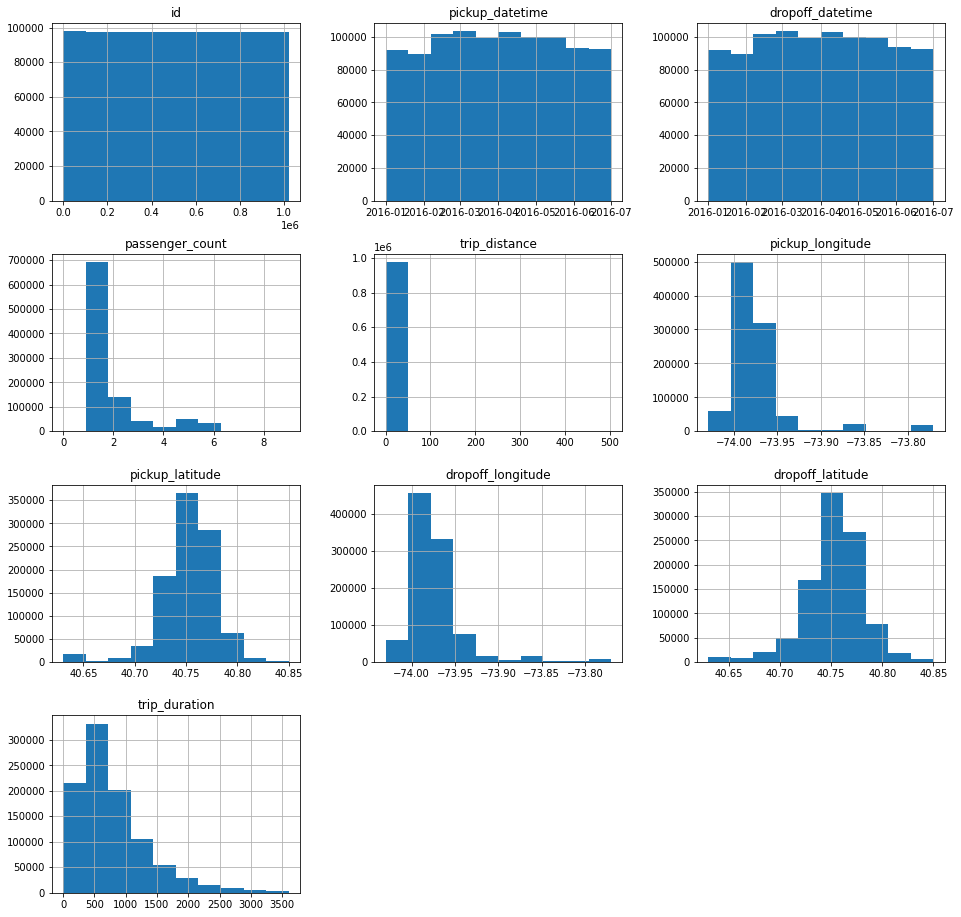

In [112]:
trips.hist(figsize=(16, 16))
plt.show()

**Comments:**
- The distributions of pickup_datetime and dropoff_datetime look more like uniform distribution. 
- The distributions of pickup_latitude and dropoff_latitude look more like normal distribution
- There are outliers in the distribtion of trip_duration, which is skewed to the right.
- There are also outliers in the passenger_count with most trip with only one passenger. 
- The pickup-longitude and the dropoff_longitude too have some outliers.

## Dectecting outliers of trip distance using boxplot.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


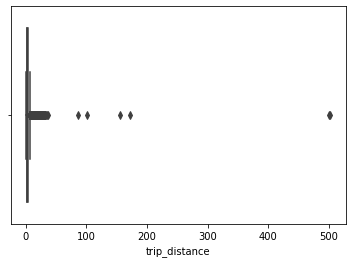

In [113]:
sns.boxplot(trips['trip_distance'])
plt.show()

**Comments:**
- There is an extreme outlier in the trip distance, thus needs to be investigated further.

## Trip distance greater than 100 miles

In [114]:
trips[trips['trip_distance']>100]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
171143,178815,1,2016-02-04 14:05:10,2016-02-04 14:56:37,1,156.2,-73.979149,40.765499,-73.782806,40.644009,1,3087.0,AR,G
248346,259490,1,2016-02-18 09:48:06,2016-02-18 09:50:27,1,501.4,-73.980087,40.782185,-73.981468,40.778519,2,141.0,I,AV
525084,548884,1,2016-04-07 21:19:03,2016-04-07 22:03:17,3,172.3,-73.783340,40.644176,-73.936028,40.737762,2,2654.0,G,AN
530340,554389,1,2016-04-08 19:19:32,2016-04-08 19:41:33,2,502.8,-73.995461,40.724884,-73.986099,40.762108,1,1321.0,X,AA
828650,867217,1,2016-06-02 21:30:17,2016-06-02 21:36:47,2,101.0,-73.961586,40.800968,-73.950165,40.802193,2,390.0,AH,J


**Comments:**

- There are 2 observation > 500, and there is a huge gap between their trip durations.
- Covering 501.4 miles distance in 141 seconds is not possible. Thus, it means sense to clip these outliers. I choose to clip them to 50. 

## Curtailing (clipping) the outliers of trip distance to 50 miles

In [115]:
trips['trip_distance']=trips['trip_distance'].clip(trips['trip_distance'].min(),50)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


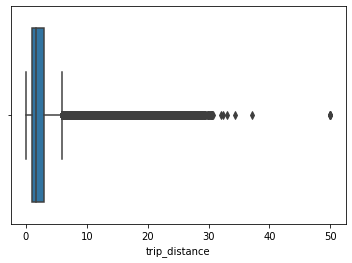

In [116]:
sns.boxplot(trips['trip_distance'])
plt.show()

## Investigating the number of passengers on trips further by countploting  Passenger_count. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


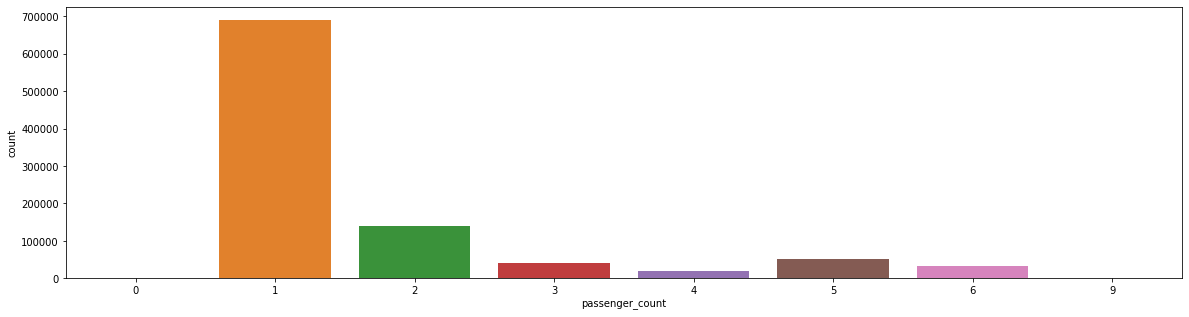

In [117]:
plt.figure(figsize=(20,5))
sns.countplot(trips.passenger_count)
plt.show()

In [118]:
trips.passenger_count.value_counts(normalize=True)*100

1    70.933356
2    14.341924
5     5.340878
3     4.113981
6     3.333405
4     1.933788
0     0.002463
9     0.000205
Name: passenger_count, dtype: float64

**Comments:**
- The vast majority of the trips (70%) have one passenger. 
- 14% of the trips have 2 passengers on them.
- Trips of more than 2 passengers  are less than 6% each. 

## Plotting countplot for pickup_neighborhood and dropoff_neighborhood

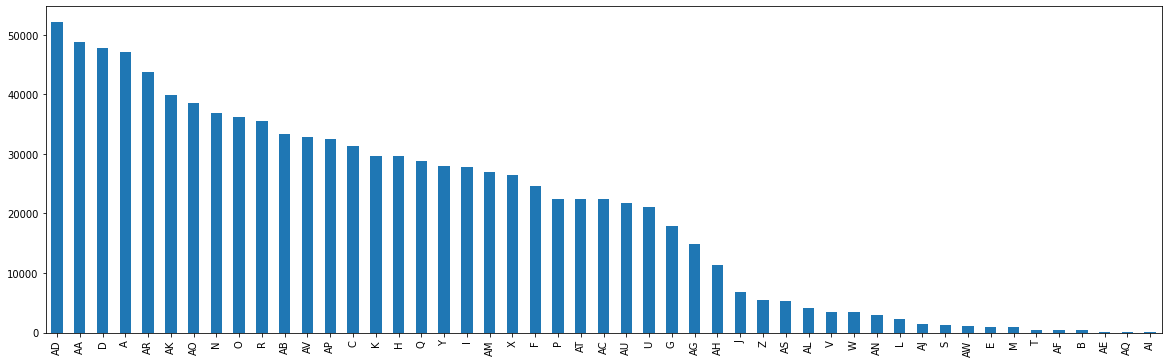

In [119]:
from pandas._libs.hashtable import value_count
trips.pickup_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar',figsize=(20,6))

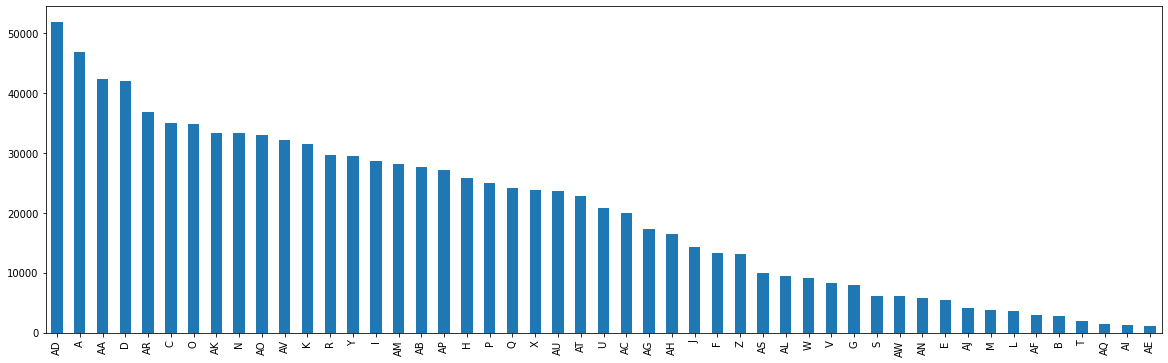

In [120]:
trips.dropoff_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(20,6))

**Comments:**
- M, T, AF, B, AE, AQ, AJ, and AE are the less busy places.
- Places like AD, A, AA, and D are the busiest places. 
- All other places are in between. 

## Bivariate analysis

### Scatterplot for trip distance and trip duration

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


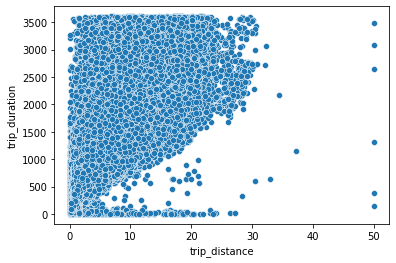

In [121]:
sns.scatterplot(trips['trip_distance'],trips['trip_duration'])

**Comments:**
- There is some positive correlation between trip_distance and trip_duration.

### Countplot passenger_count using payment_type as hue.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


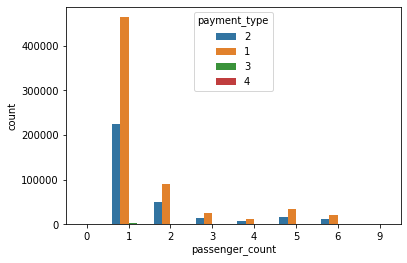

In [122]:
sns.countplot(trips['passenger_count'],hue=trips['payment_type'])

**Comments:**
- There is no clear pattern observed here.
- But we can notice that the payment types 1 is most used by far, followed by the type 2. 
- Now that I have explored the data enough, it is time to start building the models.

# Step 2: Preparing the Data for building the models

**Notes:**

Lets create entities and relationships. The three entities in this data are 
- trips 
- pickup_neighborhoods
- dropoff_neighborhoods

The data has the following relationships
- **pickup_neighborhoods --> trips:** because one neighborhood can have multiple trips that start in it. This means pickup_neighborhoods is the ``parent_entity`` and trips is the ``child_entity``
- **dropoff_neighborhoods --> trips:** because one neighborhood can have multiple trips that end in it. This means dropoff_neighborhoods is the ``parent_entity`` and trips is the ``child entity``


## Defining entities and relationships for the Deep Feature Synthesis (DFS)

In [123]:
entities = {
            "trips": (trips, "id", "pickup_datetime"),
            "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
            "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id")
            }

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

**Notes:**

- Next, we specify the cutoff time for each instance of the target_entity, in this case ``trips``
- This timestamp represents the last time data can be used for calculating features by DFS. 
- In this scenario, that would be the pickup time because we would like to make the duration prediction using data before the trip starts. 
  - e.g. If we use the dropoff time instead, we may end up having a trip which has its dropoff in the testing set while its pickup is in the training set. And, this would be bad for our prediction. 
- For the purposes of the case study, we choose to only select trips that started after January 12th, 2016. 

In [124]:
cutoff_time = trips[['id', 'pickup_datetime']]
cutoff_time = cutoff_time[cutoff_time['pickup_datetime'] > "2016-01-12"]

# Step 3: Creating the models

## Creating baseline features using Deep Feature Synthesis

Instead of manually creating features, such as "month of pickup datetime", we can let DFS come up with them automatically. It does this by 
* interpreting the variable types of the columns e.g categorical, numeric and others 
* matching the columns to the primitives that can be applied to their variable types
* creating features based on these matches

**Create transform features using transform primitives**

Features fall into two major categories, ``transform`` and ``aggregate``. In featureools, we can create transform features by specifying ``transform`` primitives. Below we specify a ``transform`` primitive called ``weekend`` and it works as follows:

* It can be applied to any ``datetime`` column in the data. 
* For each entry in the column, it assess if it is a ``weekend`` and returns a boolean. 

In this specific data, there are two ``datetime`` columns: ``pickup_datetime`` and ``dropoff_datetime``. The tool automatically creates features using the primitive and these two columns as shown below. 

## Creating a baseline model with only one transform primitive

**Defining transform primitive for weekend and define features using DFS** 

In [125]:
trans_primitives = [IsWeekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [126]:
print ("Number of features: %d" % len(features))
features

Number of features: 13


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [127]:
# Compute features and define feature matrix
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs
    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True,entities=entities, relationships=relationships)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix

In [128]:
feature_matrix1 = compute_features(features, cutoff_time)

Elapsed: 00:16 | Progress: 100%|██████████
Finishing computing...


In [129]:
preview(feature_matrix1, 5)

,dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AA,dropoff_neighborhood = D,dropoff_neighborhood = AR,dropoff_neighborhood = C,dropoff_neighborhood = O,dropoff_neighborhood = N,dropoff_neighborhood = AK,dropoff_neighborhood = AO,...,pickup_neighborhood = A,pickup_neighborhood = AR,pickup_neighborhood = AK,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = O,pickup_neighborhood = R,dropoff_neighborhoods.latitude,dropoff_neighborhoods.longitude,IS_WEEKEND(pickup_datetime)
id,,,,,,,,,,,,,,,,,,,,,
56311,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,40.721435,-73.998366,False
698423,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,40.752186,-73.976515,False
698424,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,40.775299,-73.960551,False
698425,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,40.793597,-73.969822,False
698426,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,40.766809,-73.956886,False


In [130]:
feature_matrix1.shape

(920378, 31)

## Build the Model

To build a model, I will:
* Separate the data into a portion for ``training`` (75% in this case) and a portion for ``testing`` (the remaining 25%). 
* Get the log of the trip duration so that a more linear relationship can be found.
* Train a model using a **``Linear Regression, Decision Tree** and **Random Forest** model``.

#### Transforming the duration variable with sqrt and log

(array([  4566.,  35831., 163872., 249551., 225381., 149544.,  80472.,
         38481.,  18054.,   8657.]),
 array([ 1.        ,  6.90499792, 12.80999584, 18.71499376, 24.61999167,
        30.52498959, 36.42998751, 42.33498543, 48.23998335, 54.14498127,
        60.04997918]),
 <a list of 10 Patch objects>)

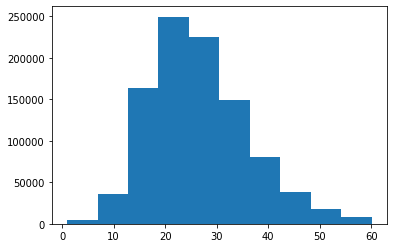

In [133]:
plt.hist(np.sqrt(trips['trip_duration']))

(array([1.81000e+02, 5.97000e+02, 7.44000e+02, 1.43900e+03, 2.86700e+03,
        2.00260e+04, 1.35785e+05, 3.69738e+05, 3.50815e+05, 9.22170e+04]),
 array([0.        , 0.81903544, 1.63807088, 2.45710632, 3.27614176,
        4.0951772 , 4.91421264, 5.73324808, 6.55228352, 7.37131896,
        8.1903544 ]),
 <a list of 10 Patch objects>)

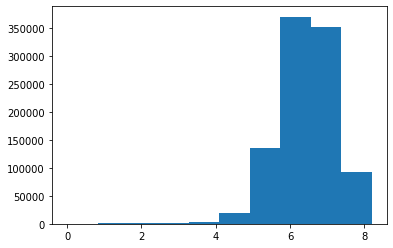

In [132]:
plt.hist(np.log(trips['trip_duration']))

**Comments:**
- We can clearly see that the sqrt transformation is giving nearly normal distribution.
- Therefore, we can choose the sqrt transformation of the dependent variable, trip_duration.

### Splitting the data into train and test

In [134]:
# Separating the whole feature matrix into train data feature matrix, using 75% training and 25% testing split. 
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix1,.75)
y_train = np.sqrt(y_train)
y_test = np.sqrt(y_test)

### Defining function for to check the performance of the model. 

In [135]:
#RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())

# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_pref(model, x_train, x_test, y_train,y_test):

    # Insample Prediction
    y_pred_train = model.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = model.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                'RSquared':
                    [r2_score(y_observed_train,y_pred_train),
                    r2_score(y_observed_test,y_pred_test )
                    ],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
            }
        )
    )

## Build Linear regression using only weekend transform primitive

In [136]:
# Defining the model
lr1=LinearRegression()
#fitting the model
lr1.fit(X_train, y_train)


LinearRegression()

In [137]:
# Checking the performance of the model
model_pref(lr1, X_train, X_test, y_train, y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.576106  6.132169  4.736641
1   Test  0.555831  6.558806  5.024874


**Comments:**
- The R-square on the trainset is around 0.58, which is greater than the R-squared on the testset which is 0.55. 
- The RMSE of the trainset is  all less than the one on the testset, and the same thing is observed for the MAE. 
-The points above suggest that the model is overfitting. 

## Building decision tree using only weekend transform primitive

In [138]:
# define the model
dt=DecisionTreeRegressor()
# fit the model
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [139]:
# Checking the performance of the model
model_pref(dt, X_train, X_test, y_train, y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.917069  2.712331  1.518055
1   Test  0.597426  6.244153  4.638653


**Comments:**
- The model is super overfitting comapared to the above OLS. 
- The gaps of the metrics between train and test is wide !
  - R-squared train = 92% and R-squared test = 60%
  - RMSE train is 2.7 and RMSE test is 6.2
  - MAE trainset is 1.51 and MAE testset is 4.6

## Building pruned decision tree using only weekend transform primitive

In [140]:
# Define the model using max_depth=7
dt_pruned=DecisionTreeRegressor(max_depth=7)
# fit the model
dt_pruned.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7)

In [141]:
# Check the performance of the model
model_pref(dt_pruned, X_train, X_test, y_train, y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.733766  4.859783  3.708634
1   Test  0.704190  5.352503  4.049448


**Comments:**
- The pruned decision tree model perfomed way better than the simple decision tree model. 
- The gaps between the metrics now have reduced drastically based on the above table. 
- But overall, it overfits the data.


## Building Random Forest using only weekend transform primitive

In [142]:
# Define the model
rf=RandomForestRegressor(n_estimators=60,max_depth=7)
# Fit the model
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=60)

In [143]:
# Check the performance of the model
model_pref(rf, X_train, X_test, y_train, y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.738265  4.818549  3.676261
1   Test  0.708235  5.315778  4.019578


**Comments:**
- The random forest performance is not too bad but still slightly overfitting. 


# Step 4

## Adding more Transform Primitives and creating new model

* Add ``Minute``, ``Hour``, ``Month``, ``Weekday`` , etc primitives
* All these transform primitives apply to ``datetime`` columns

In [144]:
# Define more transform primitives and define features using DFS
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [145]:
print ("Number of features: %d" % len(features))
features

Number of features: 23


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [146]:
# Compute features and define feature matrix
feature_matrix2 = compute_features(features, cutoff_time)

Elapsed: 00:10 | Progress: 100%|██████████
Finishing computing...


In [147]:
feature_matrix2.shape

(920378, 41)

In [148]:
feature_matrix2.head()

,WEEKDAY(pickup_datetime),trip_duration,MINUTE(pickup_datetime),DAY(dropoff_datetime),payment_type,IS_WEEKEND(dropoff_datetime),pickup_neighborhoods.latitude,DAY(pickup_datetime),dropoff_neighborhood = AD,dropoff_neighborhood = A,...,HOUR(dropoff_datetime),dropoff_neighborhoods.latitude,vendor_id,MINUTE(dropoff_datetime),MONTH(dropoff_datetime),dropoff_neighborhoods.longitude,trip_distance,MONTH(pickup_datetime),WEEKDAY(dropoff_datetime),HOUR(pickup_datetime)
id,,,,,,,,,,,,,,,,,,,,,
56311,1,645.0,0,12,1,False,40.720245,12,False,False,...,0,40.721435,2,11,1,-73.998366,1.61,1,1,0
56312,1,1270.0,2,12,2,False,40.646194,12,False,False,...,0,40.715828,2,23,1,-73.954298,16.15,1,1,0
56313,1,207.0,2,12,1,False,40.818445,12,False,False,...,0,40.818445,1,5,1,-73.948046,0.80,1,1,0
56314,1,214.0,2,12,2,False,40.729652,12,False,False,...,0,40.742531,2,6,1,-73.977943,1.33,1,1,0
56315,1,570.0,3,12,1,False,40.793597,12,False,False,...,0,40.818445,2,13,1,-73.948046,2.35,1,1,0


## Build the new models more transform features

In [149]:
# Separate the whole feature matrix into train and test data feature matrix,
X_train2, y_train2, X_test2, y_test2 = get_train_test_fm(feature_matrix2,.75)
y_train2 = np.sqrt(y_train2)
y_test2 = np.sqrt(y_test2)

## Building Linear regression using more transform primitive

In [150]:
# Defining the model
lr2=LinearRegression()
# Fitting the model
lr2.fit(X_train2, y_train2)


LinearRegression()

In [151]:
# Check the performance of the model
model_pref(lr2, X_train2, X_test2, y_train2, y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.623501  5.779195  4.273127
1   Test  0.623651  6.037346  4.537582


**Comments:**
- The metrics on the train and test are almost the same. 
- But the RMSE and the MAE are still slightly lower on the train than on the test data.
- Overall, the model is not too bad.

## Building Decision tree using more transform primitive

In [153]:
# Define the model
dt2=DecisionTreeRegressor()
# Fit the model
dt2.fit(X_train2, y_train2)

DecisionTreeRegressor()

In [154]:
# Check the performance of the model
model_pref(dt2, X_train2, X_test2, y_train2, y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.001479  0.000004
1   Test  0.712373  5.277952  3.796112


**Comments:**
- This model is really bad! 
- It strongly overfitted the data. 

## Building Pruned Decision tree using more transform primitive

In [157]:
# Define the model using max_depth=7
dt_pruned2=DecisionTreeRegressor(max_depth=4)
# Fit the model
dt_pruned2.fit(X_train2, y_train2)

DecisionTreeRegressor(max_depth=4)

In [158]:
# Check the performance of the model
model_pref(dt_pruned2, X_train2, X_test2, y_train2, y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.707305  5.095575  3.910334
1   Test  0.679915  5.567791  4.227597


**Comments:**
- The model performs pretty good by drastically reducing the gaps we've observed from the previous model. 
- But still, very slighly overfitting.

## Building Random Forest using more transform primitive

In [159]:
# Defining the model 
rf2 = RandomForestRegressor(n_estimators=60, max_depth=7)
# Fit the model
rf2.fit(X_train2, y_train2)

RandomForestRegressor(max_depth=7, n_estimators=60)

In [160]:
# Checking the performance of the model
model_pref(rf2, X_train2, X_test2, y_train2, y_test2 )  

    Data  RSquared      RMSE       MAE
0  Train  0.774626  4.471335  3.367063
1   Test  0.751804  4.902839  3.645093


**Comments:**
- The model performs fairly well with all the metrics on both the train and test sets all most the same.
- The performance of the model drastically improves when we include more transform features.


# Step 5: Add Aggregation Primitives
**Notes:**

* Now let's add aggregation primitives. These primitives will generate features for the parent entities ``pickup_neighborhoods``, and ``dropoff_neighborhood`` and then add them to the trips entity, which is the entity for which we are trying to make prediction.

## Create Models with transform and aggregate primitives. 

In [161]:
# Define more transform and aggregate primitive and define features using DFS
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [162]:
print ("Number of features: %d" % len(features))
features

Number of features: 61


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>,
 <Feature: pickup_neighborhoods.MAX(trips.trip_distance)>,
 <Feature:

In [163]:
# Compute features and define feature matrix
feature_matrix3 = compute_features(features, cutoff_time)

Elapsed: 00:19 | Progress: 100%|██████████
Finishing computing...


In [164]:
feature_matrix3.head()

,MINUTE(dropoff_datetime),dropoff_neighborhoods.MEDIAN(trips.passenger_count),dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AA,dropoff_neighborhood = D,dropoff_neighborhood = AR,dropoff_neighborhood = C,dropoff_neighborhood = O,dropoff_neighborhood = N,...,pickup_neighborhood = D,pickup_neighborhood = A,pickup_neighborhood = AR,pickup_neighborhood = AK,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = O,pickup_neighborhood = R,pickup_neighborhoods.SUM(trips.trip_distance),pickup_neighborhoods.MEAN(trips.trip_distance)
id,,,,,,,,,,,,,,,,,,,,,
56311,11,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,3904.70,3.008243
56312,23,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,19468.13,15.574504
56313,5,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,625.38,2.868716
56314,6,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,3891.78,2.285250
56315,13,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,2524.92,2.147041


In [165]:
# Separates the whole feature matrix into train data feature matrix,
X_train3, y_train3, X_test3, y_test3 = get_train_test_fm(feature_matrix3,.75)
y_train3 = np.sqrt(y_train3)
y_test3 = np.sqrt(y_test3)

## Building  Linear Regression model with transform and aggregate primitives.

In [166]:
# Defining the model
lr3=LinearRegression()
# Fitting the model
lr3.fit(X_train3, y_train3)

LinearRegression()

In [167]:
# Check the performance of the model
model_pref(lr3, X_train3, X_test3, y_train3, y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.643423  5.624220  4.134927
1   Test  0.631697  5.972457  4.464424


**Comments:**
-  The model performs well but slightly overfitting as the metrics on the train are little bit smaller than the ones on the test. 

## Building  Decision Tree model with transform and aggregate primitives.

In [168]:
# Define the model
dt3=DecisionTreeRegressor()
# Fitting the model
dt3.fit(X_train3, y_train3)

DecisionTreeRegressor()

In [169]:
# Check the performance of the model
model_pref(dt3, X_train3, X_test3, y_train3, y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.001479  0.000004
1   Test  0.645696  5.857853  4.207554


**Comments:**
- This decision tree model performs very bad by strongly overfitting the data.

## Building  Pruned Decision Tree with transform and aggregate primitives.

In [170]:
# Define the model
dt_pruned3=DecisionTreeRegressor(max_depth=7)
# Fit the model
dt_pruned3.fit(X_train3, y_train3)

DecisionTreeRegressor(max_depth=7)

In [171]:
# Check the performance of the model
model_pref(dt_pruned3, X_train3, X_test3, y_train3, y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.769212  4.524722  3.418452
1   Test  0.745722  4.962549  3.696122


**Comments:**
- The model performs well. 
- The two R-squared  are almost the same as well as the RMSE and the MAE. 
- But the two last metrics as slightly lower on the train than on the test.


## Building  Random Forest with transform and aggregate primitives.

In [172]:
# Define the model
rf3=RandomForestRegressor(n_estimators=60, max_depth=7)
# Fit the model
rf3.fit(X_train3, y_train3)

RandomForestRegressor(max_depth=7, n_estimators=60)

In [173]:
# Check the performance of the model
model_pref(rf3, X_train3, X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.776521  4.452501  3.354643
1   Test  0.753109  4.889936  3.633362


**Comments:**
- This 3rd Random Forest model performs well, and all the metrics on the train and test sets about the same, but slightly lower on the test.
-The model improves very well with the aggregate transforms. 
- The performance on the training improves drastically.
- Based on the above three rounds of models, we can make predictions using models from round 2, as it is giving almost same performances as models from round 3.
-Also, the training time is not that large as compared to model 3.


## Recapitulation:

- Sofar we've built **Linear Regression**, **Decision Tree**, and **Random Forest** models in 3 rounds:
  - **Round 1:** using only **IsWeekend** transform primitive.
  - **Round 2:** using **Minute, Hour, Day, Month, Weekday, IsWeekend** transform primitives.
  - **Round 3:** using **Minute, Hour, Day, Month, Weekday, IsWeekend** transform primitives, and **Count, Sum, Mean, Median, Std, Max, Min** aggregate primitives. 
- The Linear Regression, the Pruned Decision Trees,  and the Random Forest perfomed very well in round 3 than in rounds 1 and 2.
- We can then make our prediction using either the Linear Regression, the Pruned Decision Tree, or the Random Forest from round 3. 
- The Random Forest gave about the same performance in round 2 and round 3. But, the training time in round 2 is smaller than in round 3.
- Thus, we will use the Random Forest in round 2 for our prediction exercise. 

## Making predictions with the Random Forest model from Round 2

In [177]:
y_pred = rf2.predict(X_test2)
y_pred = y_pred**2 # undo the sqrt we took earlier
y_pred[:5]

array([1427.75480453,  403.60943774,  462.20963146,  332.71414499,
        937.6690586 ])

## Important features based on the Random Forest model from Round 2

In [178]:
feature_importances(rf2, feature_matrix2.drop(['trip_duration'],axis=1).columns, n=10)

1: Feature: trip_distance, 0.910
2: Feature: HOUR(dropoff_datetime), 0.036
3: Feature: HOUR(pickup_datetime), 0.019
4: Feature: dropoff_neighborhoods.latitude, 0.016
5: Feature: pickup_neighborhoods.longitude, 0.003
6: Feature: WEEKDAY(dropoff_datetime), 0.003
7: Feature: IS_WEEKEND(dropoff_datetime), 0.003
8: Feature: WEEKDAY(pickup_datetime), 0.003
9: Feature: IS_WEEKEND(pickup_datetime), 0.003
10: Feature: vendor_id, 0.002


**Comments:**
- The most important feature is trip-dsitance, with 91% of relevancy,  followed by Hour(dropoff_datetime) which is even less than 1%. 
- All the other features are not relevant.


## **REFERENCES:**
- Great Learning Post Graduate Program: MIT Data Science and Machine Learning: Make Data Driven decisions; Practice Project: https://www.mygreatlearning.com/mit-data-science-machine-learning-program
- Featuretools: https://www.featuretools.com